In [1]:
# Install required packages
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark pyspark

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

# Initialize Spark
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("BigDataInternshipProject") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

print("✅ Spark is ready!")
print(f"Spark version: {spark.version}")

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,840 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,124 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [2]:
# Download and create large dataset for analysis
print("📥 Downloading sample datasets...")

# Download flight data sample
!wget -q https://raw.githubusercontent.com/databricks/learning-spark/master/chapter2/py/src/data/flight-data/csv/2015-summary.csv

# Create large synthetic sales dataset
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

print("🏗️ Creating large synthetic dataset...")
np.random.seed(42)

# Generate dates for 2023
dates = [datetime(2023, 1, 1) + timedelta(days=x) for x in range(365)]
n_records = 500000  # 500K records (good size for Colab)

# Create synthetic sales data
data = {
    'transaction_id': range(1, n_records + 1),
    'date': np.random.choice(dates, n_records),
    'customer_id': np.random.randint(1, 50000, n_records),
    'product_category': np.random.choice(['Electronics', 'Fashion', 'Home', 'Books', 'Sports'], n_records),
    'product_price': np.round(np.random.uniform(10, 1000, n_records), 2),
    'quantity': np.random.randint(1, 10, n_records),
    'region': np.random.choice(['North', 'South', 'East', 'West'], n_records),
    'city': np.random.choice(['Mumbai', 'Delhi', 'Bangalore', 'Chennai', 'Kolkata', 'Pune', 'Hyderabad'], n_records)
}

# Create DataFrame and calculate total amount
df = pd.DataFrame(data)
df['total_amount'] = df['product_price'] * df['quantity']

# Save to CSV
df.to_csv('large_sales_data.csv', index=False)

print(f"✅ Dataset created successfully!")
print(f"📊 Records: {n_records:,}")
print(f"📁 File: large_sales_data.csv")
print(f"💾 Size: {df.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")

# Show sample data
print("\n🔍 Sample data preview:")
print(df.head())

📥 Downloading sample datasets...
🏗️ Creating large synthetic dataset...
✅ Dataset created successfully!
📊 Records: 500,000
📁 File: large_sales_data.csv
💾 Size: 112.9 MB

🔍 Sample data preview:
   transaction_id       date  customer_id product_category  product_price  \
0               1 2023-04-13        12400             Home         981.27   
1               2 2023-12-15        30444             Home         855.62   
2               3 2023-09-28        27342            Books         658.83   
3               4 2023-04-17        21975             Home         509.95   
4               5 2023-03-13        44534          Fashion         125.38   

   quantity region       city  total_amount  
0         8   West  Hyderabad       7850.16  
1         5  South    Kolkata       4278.10  
2         3   East     Mumbai       1976.49  
3         6  North    Kolkata       3059.70  
4         5  North      Delhi        626.90  


In [3]:
# Load data into Spark DataFrame
sales_df = spark.read.option("header", "true").option("inferSchema", "true").csv("large_sales_data.csv")

print("✅ Data loaded successfully!")
print(f"Total records: {sales_df.count():,}")
print("\n📊 Dataset Schema:")
sales_df.printSchema()

print("\n🔍 First 10 rows:")
sales_df.show(10)


✅ Data loaded successfully!
Total records: 500,000

📊 Dataset Schema:
root
 |-- transaction_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_category: string (nullable = true)
 |-- product_price: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- city: string (nullable = true)
 |-- total_amount: double (nullable = true)


🔍 First 10 rows:
+--------------+----------+-----------+----------------+-------------+--------+------+---------+------------------+
|transaction_id|      date|customer_id|product_category|product_price|quantity|region|     city|      total_amount|
+--------------+----------+-----------+----------------+-------------+--------+------+---------+------------------+
|             1|2023-04-13|      12400|            Home|       981.27|       8|  West|Hyderabad|           7850.16|
|             2|2023-12-15|      30444|            Home|       85

In [4]:
# 1. Basic Statistics
print("=== BASIC STATISTICS ===")
sales_df.describe(['product_price', 'quantity', 'total_amount']).show()

# 2. Sales by Category
print("\n=== SALES BY CATEGORY ===")
category_sales = sales_df.groupBy("product_category") \
    .agg({"total_amount": "sum", "transaction_id": "count"}) \
    .orderBy("sum(total_amount)", ascending=False)
category_sales.show()

# 3. Monthly Sales Trends
from pyspark.sql.functions import month, year, sum as spark_sum, count

print("\n=== MONTHLY SALES TRENDS ===")
monthly_sales = sales_df \
    .withColumn("month", month("date")) \
    .withColumn("year", year("date")) \
    .groupBy("year", "month") \
    .agg(spark_sum("total_amount").alias("total_sales"),
         count("transaction_id").alias("total_transactions")) \
    .orderBy("year", "month")
monthly_sales.show()

# 4. Regional Performance
print("\n=== REGIONAL PERFORMANCE ===")
regional_performance = sales_df.groupBy("region") \
    .agg(spark_sum("total_amount").alias("total_sales"),
         count("transaction_id").alias("total_transactions")) \
    .orderBy("total_sales", ascending=False)
regional_performance.show()

# 5. Top Customers Analysis
print("\n=== TOP 10 CUSTOMERS ===")
top_customers = sales_df.groupBy("customer_id") \
    .agg(spark_sum("total_amount").alias("total_spent"),
         count("transaction_id").alias("total_orders")) \
    .orderBy("total_spent", ascending=False) \
    .limit(10)
top_customers.show()

=== BASIC STATISTICS ===
+-------+-----------------+-----------------+-----------------+
|summary|    product_price|         quantity|     total_amount|
+-------+-----------------+-----------------+-----------------+
|  count|           500000|           500000|           500000|
|   mean|504.4112029800004|         4.999066|2523.060683220019|
| stddev|285.4628370885818|2.580770126995598|2069.703387536219|
|    min|             10.0|                1|             10.0|
|    max|           1000.0|                9|          8999.91|
+-------+-----------------+-----------------+-----------------+


=== SALES BY CATEGORY ===
+----------------+---------------------+--------------------+
|product_category|count(transaction_id)|   sum(total_amount)|
+----------------+---------------------+--------------------+
|         Fashion|               100400| 2.530390820699998E8|
|            Home|               100158| 2.526108137599995E8|
|     Electronics|                99929|2.5219303554000053E8|

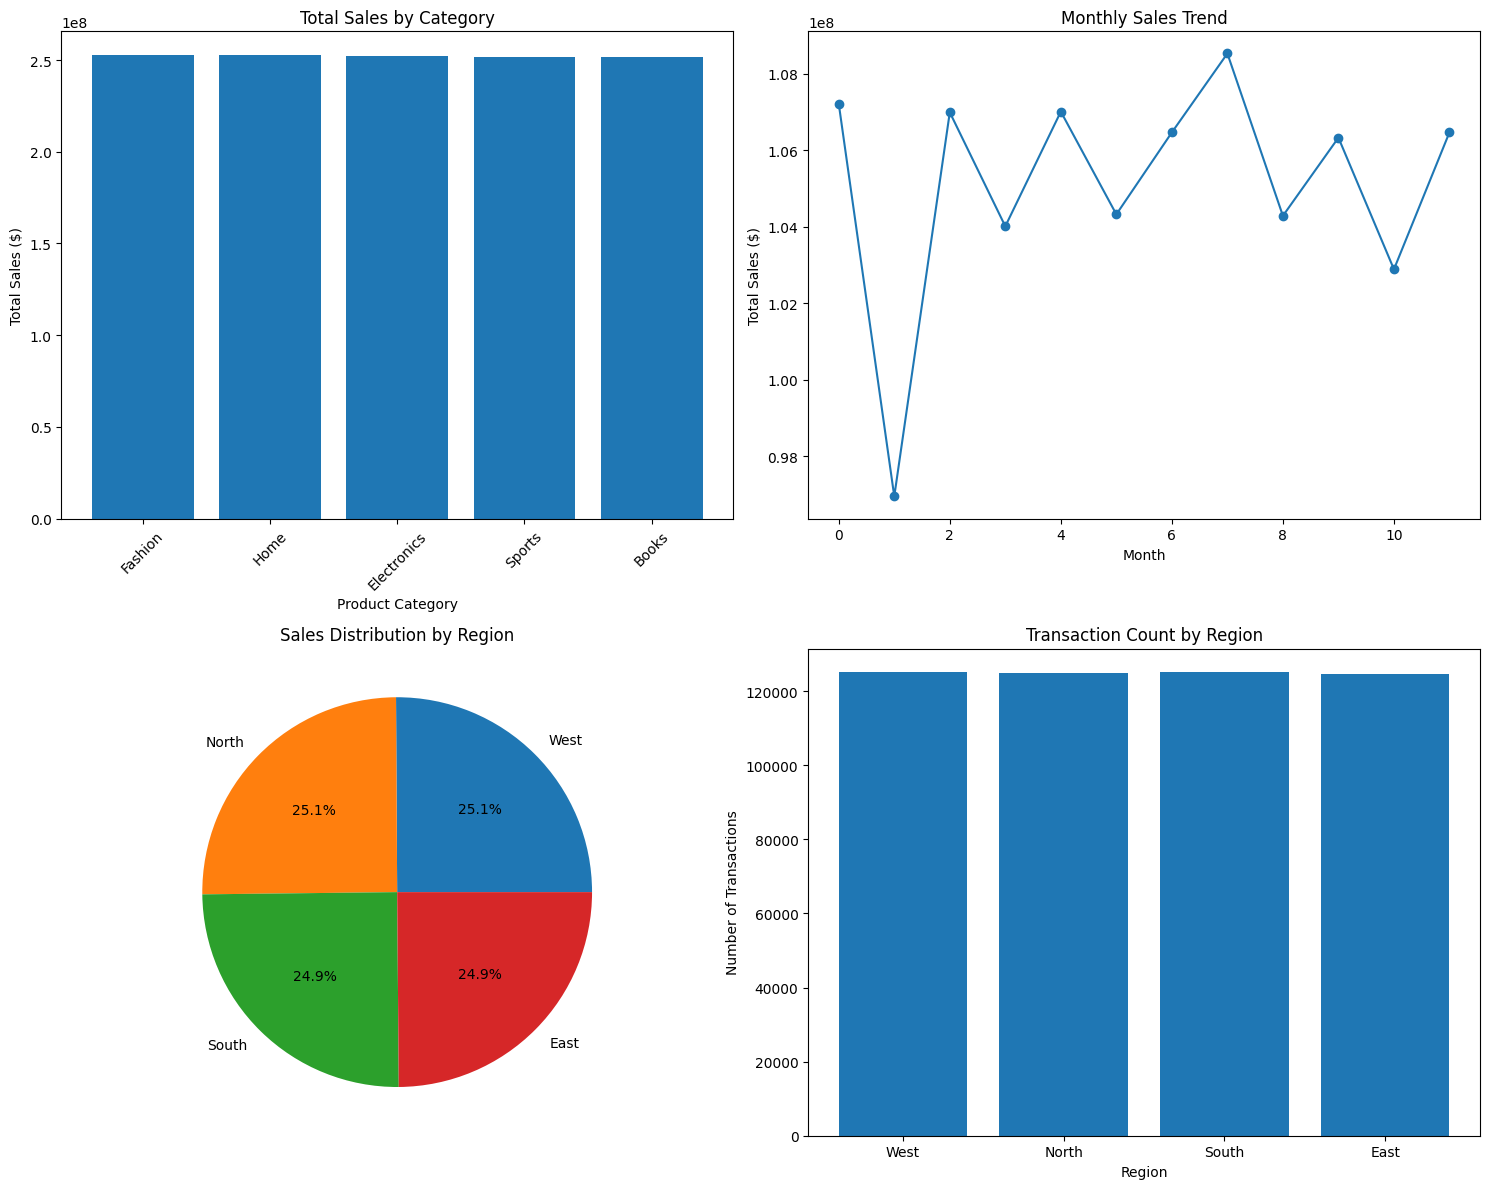

✅ Visualizations created and saved!


In [5]:
# Install plotting library
!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrames to Pandas for plotting
category_sales_pd = category_sales.toPandas()
monthly_sales_pd = monthly_sales.toPandas()
regional_performance_pd = regional_performance.toPandas()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Sales by Category
axes[0,0].bar(category_sales_pd['product_category'], category_sales_pd['sum(total_amount)'])
axes[0,0].set_title('Total Sales by Category')
axes[0,0].set_xlabel('Product Category')
axes[0,0].set_ylabel('Total Sales ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Monthly Sales Trend
monthly_sales_pd['month_year'] = monthly_sales_pd['year'].astype(str) + '-' + monthly_sales_pd['month'].astype(str).str.zfill(2)
axes[0,1].plot(range(len(monthly_sales_pd)), monthly_sales_pd['total_sales'], marker='o')
axes[0,1].set_title('Monthly Sales Trend')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Total Sales ($)')

# 3. Regional Performance
axes[1,0].pie(regional_performance_pd['total_sales'], labels=regional_performance_pd['region'], autopct='%1.1f%%')
axes[1,0].set_title('Sales Distribution by Region')

# 4. Transaction Count by Region
axes[1,1].bar(regional_performance_pd['region'], regional_performance_pd['total_transactions'])
axes[1,1].set_title('Transaction Count by Region')
axes[1,1].set_xlabel('Region')
axes[1,1].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.savefig('big_data_analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations created and saved!")


In [6]:
# Generate comprehensive summary
print("="*60)
print("🎯 BIG DATA ANALYSIS SUMMARY REPORT")
print("="*60)

total_records = sales_df.count()
total_revenue = sales_df.agg({"total_amount": "sum"}).collect()[0][0]
avg_order_value = sales_df.agg({"total_amount": "avg"}).collect()[0][0]

print(f"📊 Dataset Overview:")
print(f"   • Total Records Processed: {total_records:,}")
print(f"   • Total Revenue: ${total_revenue:,.2f}")
print(f"   • Average Order Value: ${avg_order_value:.2f}")

print(f"\n🏆 Key Insights:")
top_category = category_sales.first()
print(f"   • Best Performing Category: {top_category['product_category']}")
print(f"   • Top Category Revenue: ${top_category['sum(total_amount)']:,.2f}")

top_region = regional_performance.first()
print(f"   • Best Performing Region: {top_region['region']}")
print(f"   • Top Region Revenue: ${top_region['total_sales']:,.2f}")

print(f"\n⚡ Technology Used:")
print(f"   • Apache Spark {spark.version}")
print(f"   • PySpark for data processing")
print(f"   • Processed on Google Colab")
print("="*60)


🎯 BIG DATA ANALYSIS SUMMARY REPORT
📊 Dataset Overview:
   • Total Records Processed: 500,000
   • Total Revenue: $1,261,530,341.61
   • Average Order Value: $2523.06

🏆 Key Insights:
   • Best Performing Category: Fashion
   • Top Category Revenue: $253,039,082.07
   • Best Performing Region: West
   • Top Region Revenue: $316,557,807.15

⚡ Technology Used:
   • Apache Spark 3.4.0
   • PySpark for data processing
   • Processed on Google Colab
